# PROTEIN CLASSIFICATION ANALYSIS

In this script we will analyze the file 'merged.csv' in order to have some informations about the protein families.
The dataset contains the following columns:

1. **Accession Code**: Uniprot identifier for each entry.
2. **ChEMBL ID**: Links the entry to ChEMBL.
3. **Known mutations**: Information on known mutations.
4. **Protein families**: Indicates the family to which the protein belongs.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the data
data = pd.read_csv('/home/federica/LAB2/data_202410071624/merged.csv')
data

,Accession Code,ChEMBL DB,Known mutations,Protein families
0,A0A087X1C5,CHEMBL3542437,"S70N; S311L; C337CS""; AHMPC369..373VHMPY""; H38...",Cytochrome P450 family
1,A0AVK6,CHEMBL4630726,I674V,E2F/DP family
2,A0AVT1,CHEMBL2321622,A224T,Ubiquitin-activating E1 family
3,A1Z1Q3,CHEMBL4295630,T58I; T335M,NaN
4,A4D0S4,CHEMBL2364187,M44T; H234Y; V591F; N866S; G1028C; T1350N; H15...,NaN
...,...,...,...,...
3454,Q9H930,CHEMBL4105997,M88T; T225M; P377S,NaN
3455,Q9HB14,CHEMBL4523461,G305R; G389A,Two pore domain potassium channel (TC 1.A.1.8)...
3456,Q9NYW1,CHEMBL3309110,K170Q; V187A; L238V,G-protein coupled receptor T2R family
3457,Q9UFN0,CHEMBL3817722,R100Q,NipSnap family


In [3]:
#Data cleaning to handle missing values 
cleaned_data = data.dropna(subset=['Protein families'])
protein_family_counts = cleaned_data['Protein families'].value_counts()
protein_family_counts

Protein families
G-protein coupled receptor 1 family                                                      166
Cytochrome P450 family                                                                    48
Peptidase S1 family                                                                       30
Protein kinase superfamily, CMGC Ser/Thr protein kinase family, CDC2/CDKX subfamily       27
Protein kinase superfamily, STE Ser/Thr protein kinase family, STE20 subfamily            25
                                                                                        ... 
Helicase family, Dicer subfamily                                                           1
Potassium channel family, H (Eag) (TC 1.A.1.20) subfamily, Kv12.3/KCNH4 sub-subfamily      1
Potassium channel family, G (TC 1.A.1.2) subfamily, Kv6.1/KCNG1 sub-subfamily              1
Eukaryotic-type N-acetylglucosamine kinase family                                          1
Potassium channel family, D (Shal) (TC 1.A.1.2) subfa

In [4]:
# Display the top 10 most frequent protein families
protein_family_counts.head(10)

Protein families
G-protein coupled receptor 1 family                                                                  166
Cytochrome P450 family                                                                                48
Peptidase S1 family                                                                                   30
Protein kinase superfamily, CMGC Ser/Thr protein kinase family, CDC2/CDKX subfamily                   27
Protein kinase superfamily, STE Ser/Thr protein kinase family, STE20 subfamily                        25
Protein kinase superfamily, Ser/Thr protein kinase family                                             21
G-protein coupled receptor T2R family                                                                 21
Protein kinase superfamily, CAMK Ser/Thr protein kinase family                                        20
Protein kinase superfamily, STE Ser/Thr protein kinase family, MAP kinase kinase kinase subfamily     17
Nuclear hormone receptor family, NR1 s

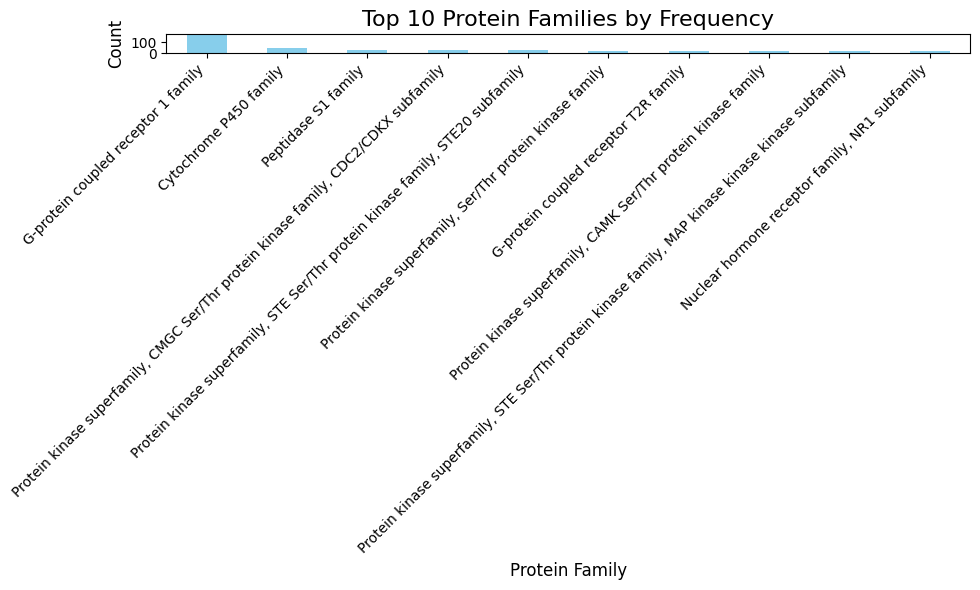

In [5]:
import matplotlib.pyplot as plt

# Plot the top 10 most frequent protein families
plt.figure(figsize=(10, 6))
protein_family_counts.head(10).plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Top 10 Protein Families by Frequency', fontsize=16)
plt.xlabel('Protein Family', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


In [6]:
# Display the 10 least frequent protein families
protein_family_counts.tail(10)


Protein families
COG6 family                                                                                          1
BCLAF1/THRAP3 family                                                                                 1
Protein-tyrosine phosphatase family, Non-receptor class CDC14 subfamily                              1
Proteasome subunit S11 family                                                                        1
ABC transporter superfamily, ABCG family, Eye pigment precursor importer (TC 3.A.1.204) subfamily    1
Helicase family, Dicer subfamily                                                                     1
Potassium channel family, H (Eag) (TC 1.A.1.20) subfamily, Kv12.3/KCNH4 sub-subfamily                1
Potassium channel family, G (TC 1.A.1.2) subfamily, Kv6.1/KCNG1 sub-subfamily                        1
Eukaryotic-type N-acetylglucosamine kinase family                                                    1
Potassium channel family, D (Shal) (TC 1.A.1.2) subfamil

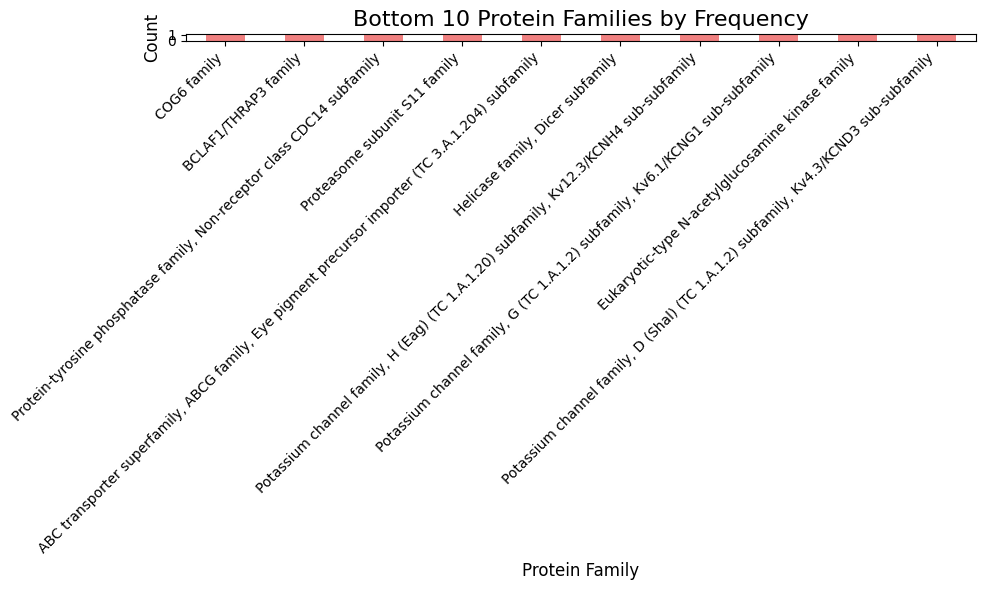

In [7]:
# Plot the 10 least frequent protein families
plt.figure(figsize=(10, 6))
protein_family_counts.tail(10).plot(kind='bar', color='lightcoral')

# Add titles and labels
plt.title('Bottom 10 Protein Families by Frequency', fontsize=16)
plt.xlabel('Protein Family', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


Since some data contains hierarchical information in the superfamily, family, and subfamily categories, we can analyze these relationships. We can break down the protein family column into these levels, assuming they're formatted as Superfamily > Family > Subfamily within the strings.

In [8]:
# filter date with the whole protein family names
filtered_data = cleaned_data[cleaned_data['Protein families'].str.contains('superfamily') & 
                             cleaned_data['Protein families'].str.contains('family') & 
                             cleaned_data['Protein families'].str.contains('subfamily')]

# show the first 5 rows of the filtered data to be sure it worked
filtered_data[['Protein families']].head()
filtered_data

,Accession Code,ChEMBL DB,Known mutations,Protein families
34,O00238,CHEMBL5476,R31C; R31H; C53R; R149W; I200K; R224H; D297N; ...,"Protein kinase superfamily, TKL Ser/Thr protei..."
40,O00311,CHEMBL5443,Q23P; I99V; G112W; F162L; I208M; E209D; K441R;...,"Protein kinase superfamily, Ser/Thr protein ki..."
53,O00444,CHEMBL3788,Y86C; R146H; A226T; S232T; P317L; N449D; W519S...,"Protein kinase superfamily, Ser/Thr protein ki..."
59,O00506,CHEMBL5552,Q64H,"Protein kinase superfamily, STE Ser/Thr protei..."
83,O14686,CHEMBL2189114,Q170H; Q170L; S337L; A476T; S543L; P647Q; P692...,Class V-like SAM-binding methyltransferase sup...
...,...,...,...,...
3344,Q9Y6E0,CHEMBL5082,A414V; L426I,"Protein kinase superfamily, STE Ser/Thr protei..."
3356,Q9Y6R4,CHEMBL4853,R157H; I294T; V335I; R566H; Q584H; H906P; E141...,"Protein kinase superfamily, STE Ser/Thr protei..."
3374,P57058,CHEMBL1795165,R157W; R591C; E625K; M648T,"Protein kinase superfamily, CAMK Ser/Thr prote..."
3386,Q5MAI5,CHEMBL4523326,S38P; R53H; H118Y; F228C; S288Y; R307C,"Protein kinase superfamily, CMGC Ser/Thr prote..."


In [9]:
# Create a copy of the filtered DataFrame to avoid SettingWithCopyWarning
filtered_data = filtered_data.copy()

# Split the 'Protein families' column and create new columns for Superfamily, Family, and Subfamily
filtered_data[['Superfamily', 'Family', 'Subfamily']] = filtered_data['Protein families'].str.extract(r'(.*superfamily.*),(.*family.*),(.*subfamily.*)')

# Verify the split
filtered_data[['Protein families', 'Superfamily', 'Family', 'Subfamily']].head()


,Protein families,Superfamily,Family,Subfamily
34,"Protein kinase superfamily, TKL Ser/Thr protei...",Protein kinase superfamily,TKL Ser/Thr protein kinase family,TGFB receptor subfamily
40,"Protein kinase superfamily, Ser/Thr protein ki...",Protein kinase superfamily,Ser/Thr protein kinase family,CDC7 subfamily
53,"Protein kinase superfamily, Ser/Thr protein ki...",Protein kinase superfamily,Ser/Thr protein kinase family,CDC5/Polo subfamily
59,"Protein kinase superfamily, STE Ser/Thr protei...",Protein kinase superfamily,STE Ser/Thr protein kinase family,STE20 subfamily
83,Class V-like SAM-binding methyltransferase sup...,Class V-like SAM-binding methyltransferase sup...,Histone-lysine methyltransferase family,TRX/MLL subfamily


In [11]:
# Analyze frequency distribution of Superfamilies, Families, and Subfamilies
superfamily_counts = filtered_data['Superfamily'].value_counts()
family_counts = filtered_data['Family'].value_counts()
subfamily_counts = filtered_data['Subfamily'].value_counts()

In [12]:
print(f"the total number of superfamiliy found is:{len(superfamily_counts)}\n they are:\n{superfamily_counts}\n")

the total number of superfamiliy found is:12
 they are:
Superfamily
Protein kinase superfamily                                                                                            332
ABC transporter superfamily                                                                                            19
Class V-like SAM-binding methyltransferase superfamily                                                                 14
TRAFAC class myosin-kinesin ATPase superfamily                                                                         14
Major facilitator superfamily                                                                                           8
TRAFAC class translation factor GTPase superfamily                                                                      5
Protein kinase superfamily, Alpha-type protein kinase family, ALPK subfamily; Transient receptor (TC 1.A.4) family      2
Class I-like SAM-binding methyltransferase superfamily                        

In [33]:
import pandas as pd

# Crea un DataFrame per superfamily_counts
superfamily_df = superfamily_counts.reset_index()
superfamily_df.columns = ['Superfamily', 'Count']  # Rinomina le colonne

# Salva la tabella HTML statica in un file
html_file_path = 'superfamily_counts.html'
superfamily_df.to_html(html_file_path, index=False)

# Visualizza la tabella HTML nel notebook Jupyter
from IPython.display import display, HTML
display(HTML(superfamily_df.to_html(index=False)))

print(f"Tabella HTML salvata in: {html_file_path}")

Superfamily,Count
Protein kinase superfamily,332
ABC transporter superfamily,19
Class V-like SAM-binding methyltransferase superfamily,14
TRAFAC class myosin-kinesin ATPase superfamily,14
Major facilitator superfamily,8
TRAFAC class translation factor GTPase superfamily,5
"Protein kinase superfamily, Alpha-type protein kinase family, ALPK subfamily; Transient receptor (TC 1.A.4) family",2
Class I-like SAM-binding methyltransferase superfamily,2
TRAFAC class OBG-HflX-like GTPase superfamily,2
TRAFAC class dynamin-like GTPase superfamily,1


Tabella HTML salvata in: superfamily_counts.html


In [13]:
print(f"the total number of families found is:{len(family_counts)}\n they are:\n{family_counts}\n")

the total number of families found is:22
 they are:
Family
Tyr protein kinase family                      77
CMGC Ser/Thr protein kinase family             53
STE Ser/Thr protein kinase family              49
CAMK Ser/Thr protein kinase family             42
AGC Ser/Thr protein kinase family              40
Ser/Thr protein kinase family                  33
TKL Ser/Thr protein kinase family              19
Histone-lysine methyltransferase family        14
Kinesin family                                 14
ABCC family                                    10
NEK Ser/Thr protein kinase family              10
CK1 Ser/Thr protein kinase family               9
Sugar transporter (TC 2.A.1.1) family           8
ABCB family                                     8
Classic translation factor GTPase family        5
OBG GTPase family                               2
LTrpC subfamily                                 2
Protein arginine N-methyltransferase family     2
Dynamin/Fzo/YdjA family                  

In [36]:
import pandas as pd

# Crea un DataFrame per superfamily_counts
family_df = family_counts.reset_index()
family_df.columns = ['Family', 'Count']  # Rinomina le colonne

# Salva la tabella HTML statica in un file
html_file_path = 'family_counts.html'
family_df.to_html(html_file_path, index=False)

# Visualizza la tabella HTML nel notebook Jupyter
from IPython.display import display, HTML
display(HTML(family_df.to_html(index=False)))

print(f"Tabella HTML salvata in: {html_file_path}")

Family,Count
Tyr protein kinase family,77
CMGC Ser/Thr protein kinase family,53
STE Ser/Thr protein kinase family,49
CAMK Ser/Thr protein kinase family,42
AGC Ser/Thr protein kinase family,40
Ser/Thr protein kinase family,33
TKL Ser/Thr protein kinase family,19
Histone-lysine methyltransferase family,14
Kinesin family,14
ABCC family,10


Tabella HTML salvata in: family_counts.html


In [14]:
print(f"the total number of subfamilies found is:{len(subfamily_counts)}\n they are:\n{subfamily_counts}\n")

the total number of subfamilies found is:95
 they are:
Subfamily
CDC2/CDKX subfamily                                        27
STE20 subfamily                                            25
MAP kinase kinase kinase subfamily                         18
Ephrin receptor subfamily                                  14
MAP kinase subfamily                                       13
                                                           ..
Heavy Metal importer (TC 3.A.1.210) subfamily               1
KLP2 subfamily                                              1
YchF/OLA1 subfamily                                         1
PRMT7 subfamily                                             1
Eye pigment precursor importer (TC 3.A.1.204) subfamily     1
Name: count, Length: 95, dtype: int64



In [37]:
import pandas as pd

# Crea un DataFrame per superfamily_counts
subfamily_df = subfamily_counts.reset_index()
subfamily_df.columns = ['Subfamily', 'Count']  # Rinomina le colonne

# Salva la tabella HTML statica in un file
html_file_path = 'subfamily_counts.html'
subfamily_df.to_html(html_file_path, index=False)

# Visualizza la tabella HTML nel notebook Jupyter
from IPython.display import display, HTML
display(HTML(subfamily_df.to_html(index=False)))

print(f"Tabella HTML salvata in: {html_file_path}")

Subfamily,Count
CDC2/CDKX subfamily,27
STE20 subfamily,25
MAP kinase kinase kinase subfamily,18
Ephrin receptor subfamily,14
MAP kinase subfamily,13
CaMK subfamily,13
PKC subfamily,12
SNF1 subfamily,12
Insulin receptor subfamily,11
TGFB receptor subfamily,11


Tabella HTML salvata in: subfamily_counts.html
